In [20]:
import os

import healpy as hp
import numpy as np
import skyproj
import proplot as pplt
import matplotlib.pyplot as plt

import rubin_sim
from rubin_sim import maf
from rubin_sim.scheduler.utils import Sky_area_generator
from rubin_sim.utils import raDec2Hpid

In [21]:
def mad(x, axis=None, no_scale=False):
    """
    median absolute deviation - scaled like a standard deviation

        mad = 1.4826*median(|x-median(x)|)

    Parameters
    ----------
    x: array-like
        array to take MAD of
    axis: int
        axis over which to take mode (default: None)
    no_scale: bool
        return MAD not scaled to match a Gaussian (default: False)

    Returns
    -------
    mad: float
        MAD of array x
    """
    kd = True if axis is not None else False
    mad = np.median(np.abs(x - np.median(x, axis=axis, keepdims=kd)), axis=axis)
    if no_scale:
        return mad
    else:
        return 1.4826 * mad

In [22]:
nside = 128

sm = Sky_area_generator(nside=nside)
footprints_hp_array, labels = sm.return_maps()
wfd_indx = np.where((labels == 'lowdust') | (labels == 'virgo'))[0]

In [154]:
def _apply_wfd_mask(maps):
    maps[~wfd_indx] = -9999
    maps.mask = True
    maps.mask[wfd_indx] = False
    maps.mask[maps < 0] = True
    return maps

def compute_map_stats(maps_arr, noroll_maps_arr):

    mdata = np.zeros(
        len(maps_arr),
        dtype=[
            (col, "f8", (2,))
            for col in [
                "med",
                "sd",
                "pt",
                "area",
            ]
        ] + [
            (col, "f8")
            for col in ["tlost", "alost"]
        ],
    )
    
    for i in range(len(maps_arr)):
        fmaps = maps_arr[i].copy()
        fmaps[~wfd_indx] = -9999
        fmaps = fmaps[fmaps > 15]
        if fmaps.shape == (0,):
            continue
        
        fnoroll_maps = noroll_maps_arr[i].copy()
        fnoroll_maps[~wfd_indx] = -9999        
        fnoroll_maps = fnoroll_maps[fnoroll_maps > 15]

        if fnoroll_maps.shape == (0,):
            continue
            
        mdata["med"][i, 0] = np.median(fmaps)
        mdata["med"][i, 1] = np.median(fnoroll_maps)

        mdata["sd"][i, 0] = mad(fmaps)
        mdata["sd"][i, 1] = mad(fnoroll_maps)
        
        ptval = 25
        mdata["pt"][i, 0] = np.percentile(fmaps, [ptval])
        mdata["pt"][i, 1] = np.percentile(fnoroll_maps, [ptval])
        
        mdata["tlost"][i] = (mdata["pt"][i, 1] - mdata["pt"][i, 0])/mdata["pt"][i, 1]

        ns = 3
        mn = np.median(fnoroll_maps)
        _sd = mad(fnoroll_maps)
        cut = mn-ns*_sd
        cut = mdata["pt"][i, 1]
        mdata["area"][i, 0] = np.sum(fmaps > cut)
        mdata["area"][i, 1] = np.sum(fnoroll_maps > cut)
        mdata["alost"][i] = (
            (mdata["area"][i, 1] - mdata["area"][i, 0])/mdata["area"][i, 1]
        )

    return mdata

In [155]:
noroll_maps_arr = fitsio.read("noroll_v2.0_10yrs_nside128_bins40.fits")


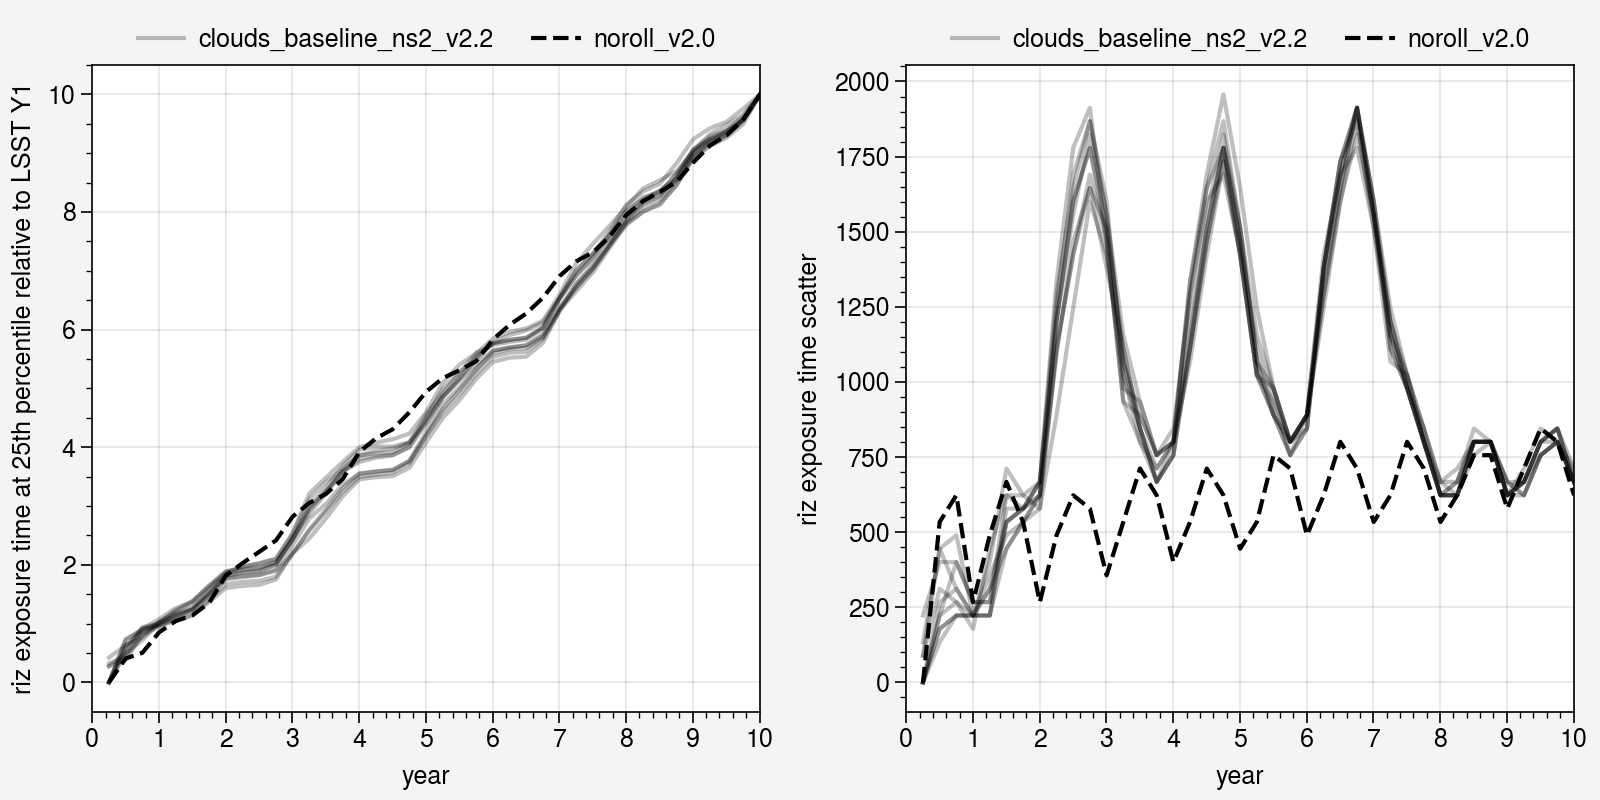

In [156]:
import proplot as pplt
import glob

alpha = 0.25

rlabel = "clouds_baseline_ns2_v2.2"
nrlabel = "noroll_v2.0"

fig, axs = pplt.subplots(ncols=2, nrows=1, figsize=(8, 4), sharey=0, sharex=0)

fnames = glob.glob("clouds_baseline_cloudso*_ns2_v2.2_10yrs_nside128_bins40.fits")
for i, fname in enumerate(fnames):
    maps_arr = fitsio.read(fname)
    mdata = compute_map_stats(maps_arr, noroll_maps_arr)

    xy = np.linspace(0, 3653, 41)[1:]/365
    
#     axs[0, 0].plot(xy, mdata["tlost"], 'k', label="depth" if i == 0 else None, alpha=alpha)
#     axs[0, 0].plot(xy, mdata["alost"], 'k--', label="area" if i == 0 else None, alpha=alpha)
#     axs[0, 0].set_ylabel("frac depth or area lost at 25th percentile")
#     if i == 0:
#         axs[0, 0].legend(loc='t', frameon=False)

    axs[0].plot(
        xy, 
        mdata["pt"][:, 0]/(mdata["pt"][-1, 0]/10), 
        'k', 
        label=rlabel if i == 0 else None,
        alpha=alpha,
    )
#     if i == 0:
#         axs[0].plot(
#             [0, 10], 
#             [0, 10], 
#             'k:', 
#             label="uniform" if i == 0 else None,
#         )
    if i == 0:
        axs[0].plot(xy, mdata["pt"][:, 1]/(mdata["pt"][-1, 1]/10), 'k--', label=nrlabel if i == 0 else None)
    axs[0].set_ylabel("riz exposure time at 25th percentile relative to LSST Y1")
    if i == 0:
        axs[0].legend(loc="t", frameon=False)

#     axs[1, 0].plot(xy, mdata["pt"][:, 1] - mdata["pt"][:, 0], 'k', alpha=alpha)
#     axs[1, 0].set_ylabel("rolling riz exposure time deficit at 25th percentile [sec]")

    axs[1].plot(xy, mdata["sd"][:, 0], 'k', label=rlabel if i == 0 else None, alpha=alpha)
    if i == 0:
        axs[1].plot(xy, mdata["sd"][:, 1], 'k--', label=nrlabel if i == 0 else None)
    axs[1].set_ylabel("riz exposure time scatter")
    if i == 0:
        axs[1].legend(loc="t", frameon=False)

    for ax in axs:
        ax.set_xlim(0, 10)
        ax.set_xlabel("year")
        ax.format(xticks=np.arange(0, 11))
        
fig.savefig(rlabel + ".png", dpi=300)

3.753082191780822


(array([1.15781747e-06, 1.64024141e-06, 4.82423945e-06, 2.27704102e-05,
        4.61197291e-05, 4.85318489e-05, 3.04891933e-05, 1.79461708e-05,
        1.77532012e-05, 2.43141668e-05, 3.87868852e-05, 3.19364652e-05,
        3.57958567e-05, 2.45071364e-05, 1.66918685e-05, 1.29289617e-05,
        1.00344181e-05, 8.10472227e-06, 8.49066143e-06, 6.56096565e-06,
        8.97308538e-06, 8.87660059e-06, 8.58714622e-06, 7.81526791e-06,
        9.16605495e-06, 1.02273876e-05, 9.06957016e-06, 1.15781747e-05,
        1.92004730e-05, 3.42521001e-05, 1.11150477e-04, 2.06380964e-04,
        3.57283174e-04, 5.25552646e-04, 6.25800341e-04, 7.89727998e-04,
        5.90293939e-04, 5.28543674e-04, 4.75091101e-04, 4.31287007e-04,
        4.43347605e-04, 2.87331702e-04, 2.14968110e-04, 1.42701003e-04,
        8.04683140e-05, 4.47689421e-05, 1.25430226e-05, 4.14884593e-06,
        1.15781747e-06, 5.78908734e-07]),
 array([ 120.,  276.,  432.,  588.,  744.,  900., 1056., 1212., 1368.,
        1524., 1680., 1

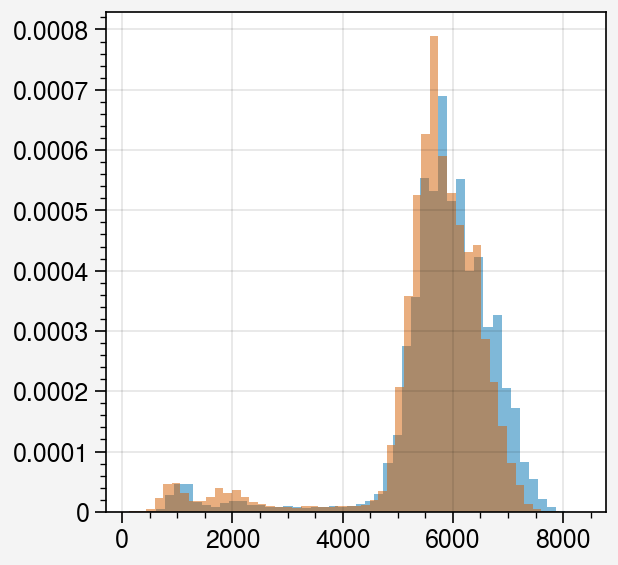

In [150]:
i = 14
print(xy[i])

fmaps = maps_arr[i].copy()
fmaps[~wfd_indx] = -9999
fmaps = fmaps[fmaps > 15]

fnoroll_maps = noroll_maps_arr[i].copy()
fnoroll_maps[~wfd_indx] = -9999        
fnoroll_maps = fnoroll_maps[fnoroll_maps > 15]


fig, axs = pplt.subplots()

axs.hist(fmaps, density=True, bins=50, alpha=0.5)
axs.hist(fnoroll_maps, density=True, bins=50, alpha=0.5)